In [1]:
import tensorflow as tf
tf.keras.utils.set_random_seed(906)  
tf.config.experimental.enable_op_determinism()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import FileLink
import matplotlib.pyplot as plt
import os
import pandas as pd
from keras.preprocessing import image
import skopt
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer 
import tensorflow as tf
from tensorflow.python.keras import backend as K
import pandas as pd

In [3]:
train_path= "140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train"
valid_path= "140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid"
test_path= "140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test"

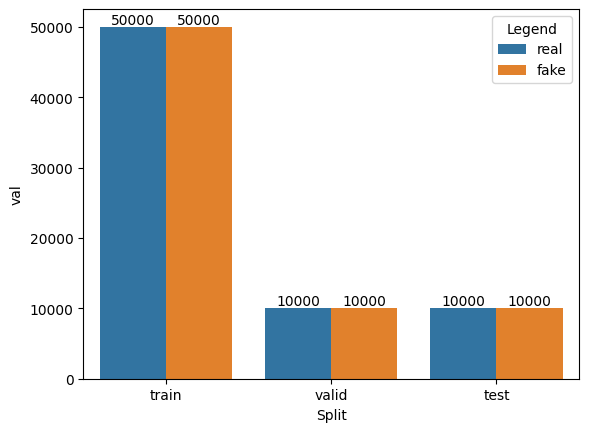

In [4]:
dirs= ['train', 'val', 'test']

real = [len(os.listdir(train_path+"/real/")), len(os.listdir(valid_path+"/real/")), len(os.listdir(test_path+"/real/"))]
fake = [len(os.listdir(train_path+"/fake/")), len(os.listdir(valid_path+"/fake/")), len(os.listdir(test_path+"/fake/"))]

df = pd.DataFrame([['real','train',real[0]],['real','valid',real[1]],['real','test',real[2]],
                   ['fake','train',fake[0]],['fake','valid',fake[1]],['fake','test',fake[2]]], 
                   columns=['Legend','Split','val'])

ax= sns.barplot(data=df, x='Split', y='val', hue='Legend')
for i in ax.containers:
    ax.bar_label(i,)

In [5]:
traindatagen= ImageDataGenerator(rescale= 1./255, horizontal_flip= True)
datagen= ImageDataGenerator(rescale= 1./255)

train_generator= traindatagen.flow_from_directory(
    train_path,
    target_size= (224,224),
    batch_size= 32,
    class_mode= 'binary',
    #shuffle= False
)

valid_generator= datagen.flow_from_directory(
    valid_path,
    target_size= (224,224),
    batch_size= 32,
    class_mode= 'binary',
    #shuffle= False
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [6]:
train_generator.class_indices

{'fake': 0, 'real': 1}

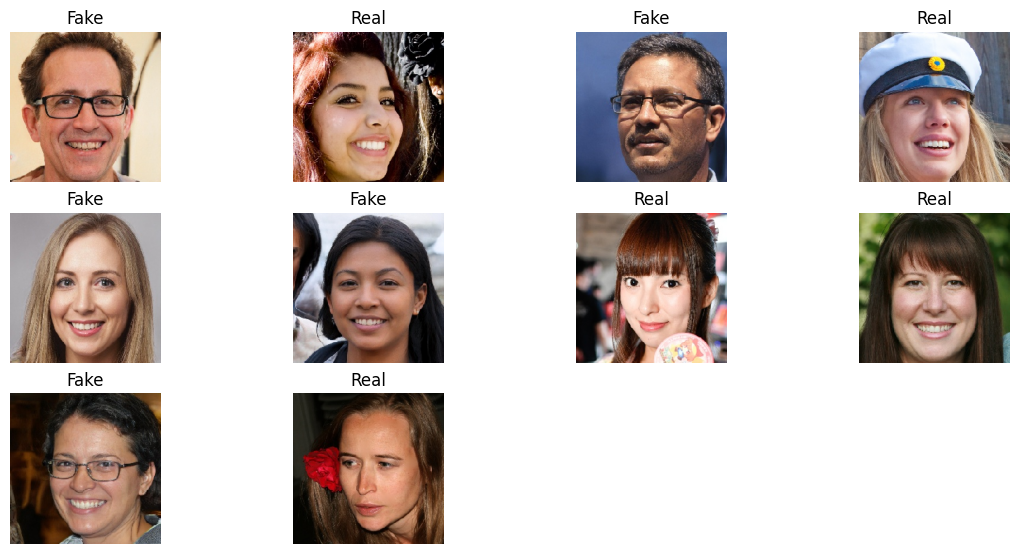

In [7]:
plt.figure(figsize= (14, 9))
classes= ['Fake', 'Real']
x,y= train_generator.next()
for i in range(10):
    plt.subplot(4, 4, i+1)
    image= x[i]
    label= classes[int(y[i])]
    plt.title(label)
    plt.imshow(image)
    plt.axis("off")

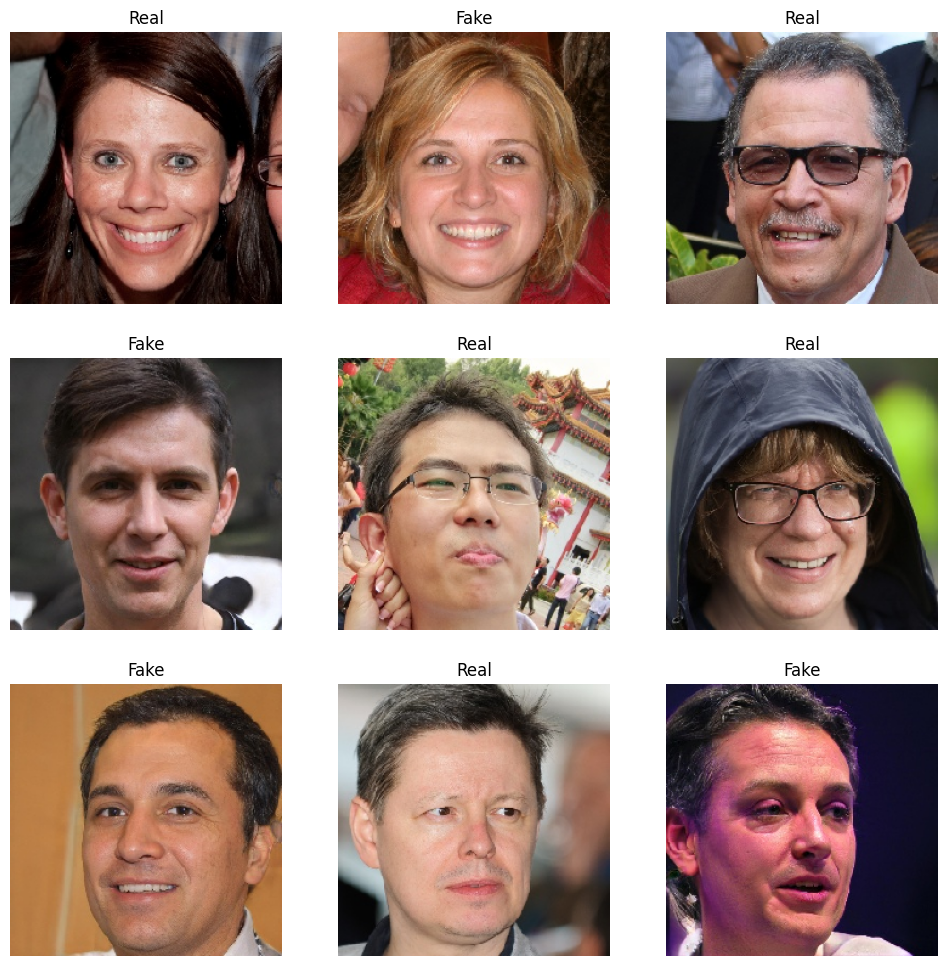

In [8]:
import cv2
from PIL import Image

plt.figure(figsize= (12, 12))
x,y= train_generator.next()
for i in range(9):
    plt.subplot(3, 3, i+1)
    image= x[i]
    label= classes[int(y[i])]
    plt.title(label)
    plt.imshow(image)
    plt.axis("off")

In [9]:
input_shape= (224,224,3)

base_model= tf.keras.applications.inception_resnet_v2.InceptionResNetV2(input_shape=(224,224,3), include_top= False, weights= 'imagenet')
base_model.trainable = False

model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
model.compile(
        loss= 'binary_crossentropy',
        optimizer= tf.keras.optimizers.experimental.SGD(),
        metrics= ['accuracy'])

219055592/219055592 [==============================] - 1s 0us/step


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 1)                 1537      
                                                                 
Total params: 54,338,273
Trainable params: 1,537
Non-trainable params: 54,336,736
_________________________________________________________________


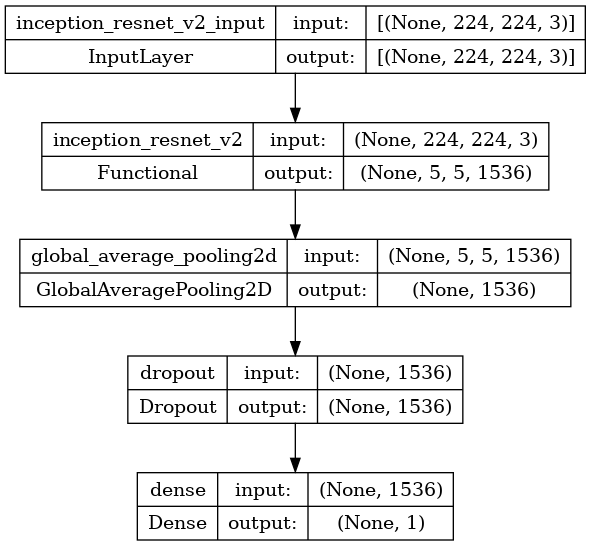

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [12]:
len(model.trainable_variables)

2

In [13]:
history= model.fit(train_generator,
                   epochs= 5,
                   steps_per_epoch= 500,
                   validation_data= valid_generator)

Epoch 1/5
500/500 [==============================] - 498s 964ms/step - loss: 0.6277 - accuracy: 0.6540 - val_loss: 0.5773 - val_accuracy: 0.6952
Epoch 2/5
500/500 [==============================] - 395s 791ms/step - loss: 0.5845 - accuracy: 0.6954 - val_loss: 0.5488 - val_accuracy: 0.7181
Epoch 3/5
500/500 [==============================] - 412s 825ms/step - loss: 0.5706 - accuracy: 0.7036 - val_loss: 0.5355 - val_accuracy: 0.7344
Epoch 4/5
500/500 [==============================] - 296s 592ms/step - loss: 0.5589 - accuracy: 0.7135 - val_loss: 0.5287 - val_accuracy: 0.7345
Epoch 5/5
500/500 [==============================] - 385s 771ms/step - loss: 0.5525 - accuracy: 0.7210 - val_loss: 0.5287 - val_accuracy: 0.7324


In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

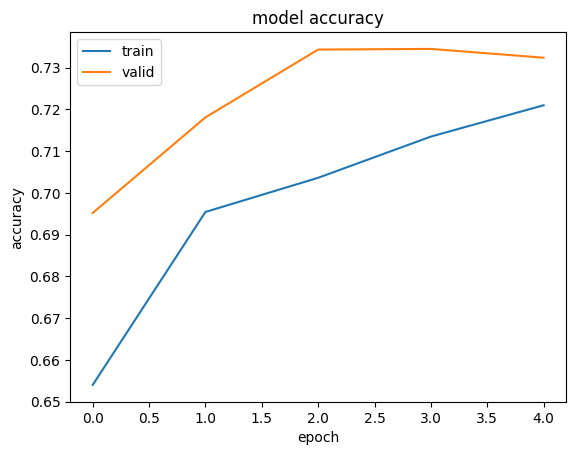

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

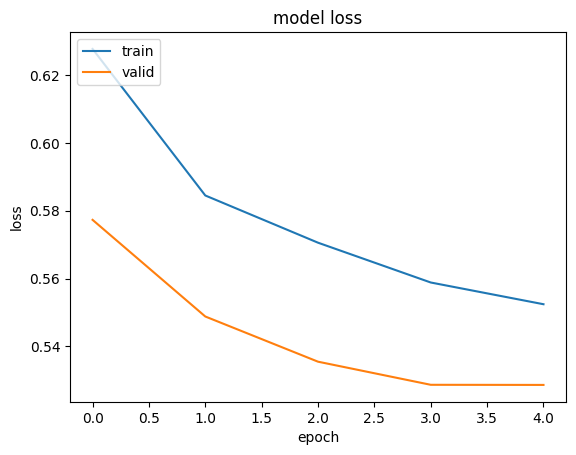

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [18]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  780


In [19]:
model.compile(
        loss= 'binary_crossentropy',
        optimizer= tf.keras.optimizers.experimental.SGD(),
        metrics= ['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 1)                 1537      
                                                                 
Total params: 54,338,273
Trainable params: 53,510,161
Non-trainable params: 828,112
_________________________________________________________________


In [21]:
len(model.trainable_variables)


426

In [22]:
history_fine = model.fit(train_generator,
                         epochs= 10,
                         steps_per_epoch= 500,
                         initial_epoch= history.epoch[-1],
                         validation_data=valid_generator)

Epoch 5/10
500/500 [==============================] - 556s 1s/step - loss: 0.4179 - accuracy: 0.8099 - val_loss: 0.2992 - val_accuracy: 0.8744
Epoch 6/10
500/500 [==============================] - 566s 1s/step - loss: 0.2526 - accuracy: 0.8959 - val_loss: 0.2049 - val_accuracy: 0.9166
Epoch 7/10
500/500 [==============================] - 506s 1s/step - loss: 0.1680 - accuracy: 0.9333 - val_loss: 0.1508 - val_accuracy: 0.9408
Epoch 8/10
500/500 [==============================] - 504s 1s/step - loss: 0.1348 - accuracy: 0.9485 - val_loss: 0.1374 - val_accuracy: 0.9492
Epoch 9/10
500/500 [==============================] - 492s 985ms/step - loss: 0.1132 - accuracy: 0.9567 - val_loss: 0.1132 - val_accuracy: 0.9585
Epoch 10/10
500/500 [==============================] - 487s 975ms/step - loss: 0.0861 - accuracy: 0.9674 - val_loss: 0.0929 - val_accuracy: 0.9668


In [23]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

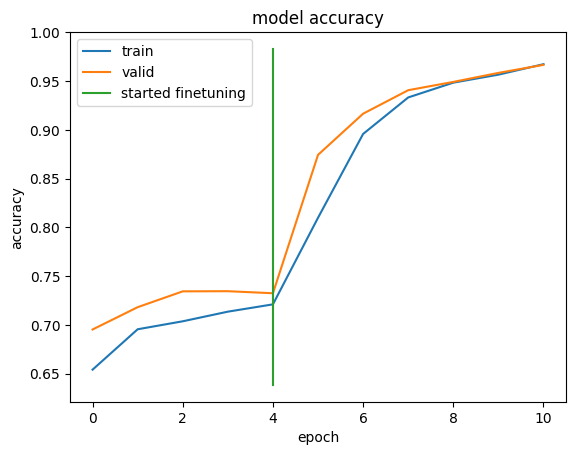

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot([4,4], plt.ylim(), label='Start Fine Tuning') 
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid', 'started finetuning'], loc='upper left')
plt.show()

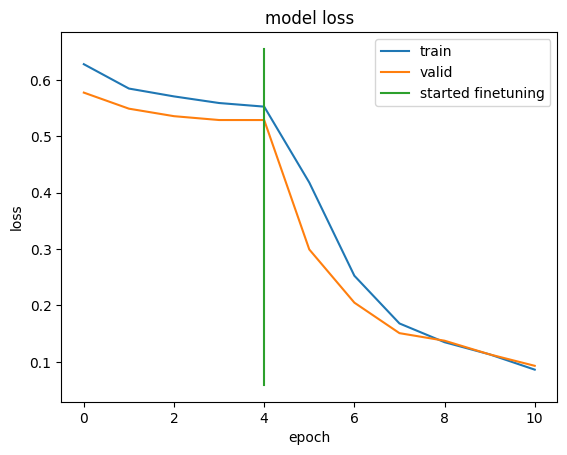

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot([4,4], plt.ylim(), label='Start Fine Tuning') 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid', 'started finetuning'], loc='upper right')
plt.show()

In [26]:
model.save("newmodel1.h5")
FileLink('newmodel1.h5')

/kaggle/working/newmodel1.h5

In [27]:
json_config = model.to_json()

In [28]:
type(json_config)
with open("json-config.txt", "w") as fin:
    fin.write(json_config)

In [29]:
model.save("model.keras")
FileLink("model.keras")

/kaggle/working/model.keras